<h1>Cora Classification using graph neural network </h1>


The 2708 scientific publications that make up the Cora dataset have been divided into seven categories. A 0/1-valued word vector denoting the absence/presence of the matching word from the dictionary is used to describe each publication in the dataset. 1433 distinct words make up the dictionary. <br>  <br>
Publications (Papers, Books, etc.) = Nodes<br>

Citations = Edges<br>
Word vectors = node features<br>
7 labels = the type of publication, such as probabilistic methods, neural networks, rule learning, and reinforcement learning. <br>

There is a one graph with:
    
Number of features: 1433 

Number of classes: 7
    
    

In [4]:
# Install required libraries

!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install spektral==0.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1. Import Packages**

In [6]:
# Import Packages

import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# **2. Prepare the Dataset** 

2,708 scientific papers that have been divided into one of 7 classifications make up the Cora dataset. There are 5,429 linkages in the citation network. A binary word vector of size 1,433 is present in each paper, signifying the existence of a corresponding word.

<h2>2.1 Extract Cora Dataset<h2>

In [7]:
!tar -xvf '/content/cora.tgz'

cora/
cora/README
cora/cora.cites
cora/cora.content


<h2> 2.2 Data Loading and Preprocessing <h2>

We'll utilize the edges that connect the (from file <b>cora.cites</b>).<br>
The  <b>cora.content</b> file is used to load the nodes.

In the file <b>cora.content</b>:<br>
The <b>node name</b> is defined by the **first** element.<br>
The **features of the node** are defined by the **second** and subsequent elements.<br>
The **last** element displays the **label for that specific node**.<br>

In the file <b>cora.cites</b>:<br>
Each line represents a tuple of related nodes.

In [8]:
##loading the data and visulaizing in csv

all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data = pd.read_csv(
                    f,
                    sep="\t",
                    header=None,
                    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
                    )


        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
              all_edges = pd.read_csv(
                    f,
                    sep="\t",
                    header=None,
                    names=["target", "source"],
                    )
                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)
all_edges = shuffle(all_edges,random_state=random_state)

In [9]:
all_edges.head()

,target,source
4938,522338,1132864
2881,35797,1050679
4605,230879,230884
1225,6213,1107355
748,3191,310742


In [10]:
all_data.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
2150,7430,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Reinforcement_Learning
389,159897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
841,1127530,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
2027,1107355,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
1725,248395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks


In [11]:
## display the count of the papers in each subject
print(all_data.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [12]:
## convert the paper ids and the subjects into zero-based indices
class_values = sorted(all_data["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(all_data["paper_id"].unique()))}

all_data["paper_id"] = all_data["paper_id"].apply(lambda name: paper_idx[name])
all_edges["source"] = all_edges["source"].apply(lambda name: paper_idx[name])
all_edges["target"] = all_edges["target"].apply(lambda name: paper_idx[name])
all_data["subject"] = all_data["subject"].apply(lambda value: class_idx[value])

**Let's now see the citation graph in visual form. The graph's nodes each stand in for a paper, and the subject of each paper is indicated by the color of the node. Please take note that we only display a subset of the dataset's papers.**

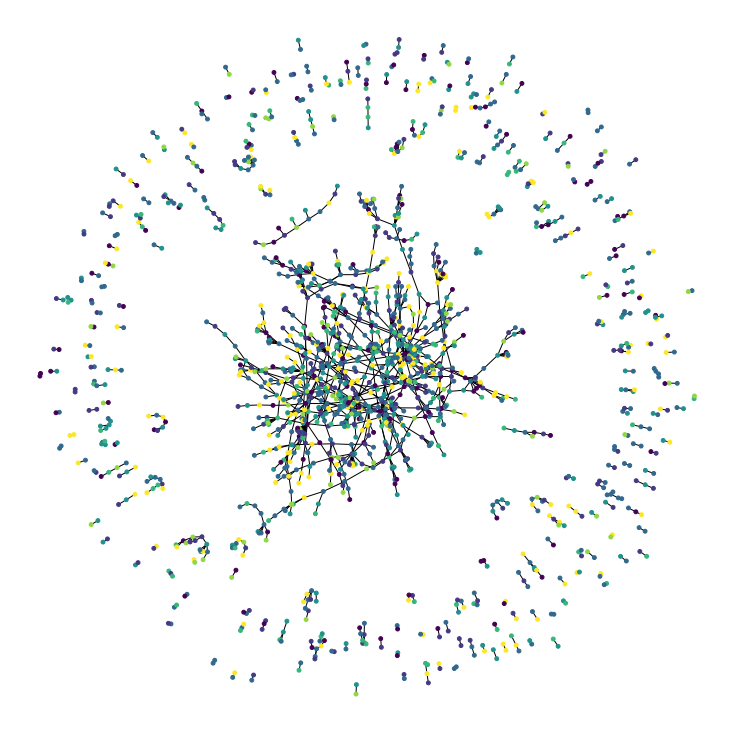

In [13]:
plt.figure(figsize=(10, 10))
colors = all_data["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(all_edges.sample(n=1500))
subjects = list(all_data[all_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [14]:
#loading the data again normally

all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

**Parsing the data**<br>
Nodes, edges, features and classes

In [15]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Theory', 'Case_Based', 'Reinforcement_Learning', 'Neural_Networks', 'Rule_Learning', 'Genetic_Algorithms', 'Probabilistic_Methods'}

Number of classes:  7


<h2> 2.3 Build a graph and Prepare data for the graph model on NetworkX using the obtained nodes and edges list <h2>

In [16]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


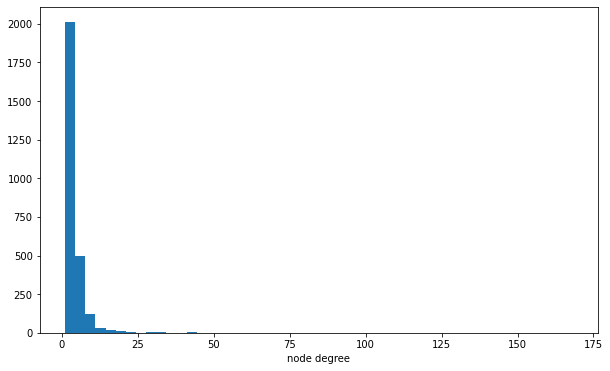

In [17]:
## Node Degree - Degree in graph theory means the number of edges joining a vertex (node) in a graph.

degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.011821204285186553


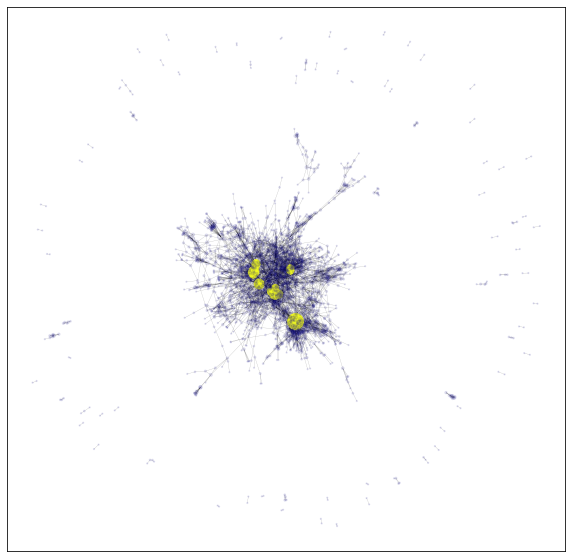

In [18]:
## plot the graph to see where the top 10 nodes with the highest degree are located

pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 4000, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

Yellow dots represent the top 10 nodes with the highest degree, while gray dots represent the other nodes.

<h2>Prepare Dataset for models <h2>

**Split the dataset for training, validation, and test then set the mask**

In [19]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx, test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [20]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

**Show Data Distribution**

In [21]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [22]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Neural_Networks': 20, 'Rule_Learning': 20, 'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Case_Based': 20})


In [23]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 196, 'Probabilistic_Methods': 76, 'Reinforcement_Learning': 66, 'Theory': 64, 'Case_Based': 47, 'Genetic_Algorithms': 30, 'Rule_Learning': 21})


**Data pre-processing - Convert the labels to one hot encoding**

In [24]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder, label_encoder.classes_

labels_encoded, label_encoder, classes = encode_label(labels)

# **3. Machine learning Models**



> **We are developing and training 2 models that are:**

1.   Fully-Connected Neural Networks (FNN)
2.   Graph Convolutional Neural Networks (GCNN)

Decision tree based models (here, XGBoost Regressor and Random forest) do not require feature scaling to be performed as they are not sensitive to the the variance in the data. Whereas, Linear regression and SVR need scalar standard.

> We are evaluating our ML models by using **Subset Accuracy** performance metrics (also known as exact match ratio) indicating the percentage of samples that have their label classified correctly:

1. Subset Accuracy: Subset Accuracy is how close or far is the measurements of predictions or observations are to their actual values.

    **Formula**

                Subset Accuracy = 100% - ER
                ER = |Observed Value - Actual Value|/Actual Value × 100.

   where:
   
   - ER = Error Rate,
   
   Subset Accuracy value ranges from 0% to 100%, 100% means model performance is best and 0% means model performance is worst.

<h2>3.1 Build and Train Fully-Connected Neural Networks (FNN)<h2>

In [25]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

model_fnn.summary()


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               183552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 218,375
Trainable params: 218,375
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                EarlyStopping(patience=es_patience,  restore_best_weights=True),
                tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 494ms/step - loss: 0.2191 - acc: 0.1429 - val_loss: 0.4336 - val_acc: 0.2500
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1755 - acc: 0.3429

1/1 [==============================] - 0s 260ms/step - loss: 0.1755 - acc: 0.3429 - val_loss: 0.4004 - val_acc: 0.3120
Epoch 3/200
1/1 [==============================] - 0s 266ms/step - loss: 0.1418 - acc: 0.4786 - val_loss: 0.3708 - val_acc: 0.3760
Epoch 4/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1152 - acc: 0.6357 - val_loss: 0.3413 - val_acc: 0.4560
Epoch 5/200
1/1 [==============================] - 0s 249ms/step - loss: 0.0926 - acc: 0.7071 - val_loss: 0.3074 - val_acc: 0.5100
Epoch 6/200
1/1 [==============================] - 0s 260ms/step - loss: 0.0737 - acc: 0.8500 - val_loss: 0.2723 - val_acc: 0.5740
Epoch 7/200
1/1 [==============================] - 0s 254ms/step - loss: 0.0575 - acc: 0.8786 - val_loss: 0.2513 - val_acc: 0.5960
Epoch 8/200
1/1 [==============================] - 0s 263ms/step - loss: 0.0467 - acc: 0.9571 - val_loss: 0.2483 - val_acc: 0.5620
Epoch 9/200
1/1 [==============================] - 0s 256ms/step - loss: 0.0445 - acc: 0.9714 -

<h2> 3.2 Build and Train Graph Convolutional Neural Networks (GCNN) </h2>

In [27]:
channels = 16           
dropout = 0.5         
l2_reg = 5e-4           
learning_rate = 1e-2
epochs = 200    
es_patience = 10

A = GraphConv.preprocess(A).astype('f4')

X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])
model_gcnn = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model_gcnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model_gcnn.summary()

tbCallBack_GCNN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCNn = [tbCallBack_GCNN]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout_2[0][0]                  
                                                                 input_2[0][0]                

In [28]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model_gcnn.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 441ms/step - loss: 0.1164 - acc: 0.1571 - val_loss: 0.3629 - val_acc: 0.3560
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1089 - acc: 0.4500

1/1 [==============================] - 0s 259ms/step - loss: 0.1089 - acc: 0.4500 - val_loss: 0.3514 - val_acc: 0.4580
Epoch 3/200
1/1 [==============================] - 0s 293ms/step - loss: 0.1027 - acc: 0.5143 - val_loss: 0.3392 - val_acc: 0.4840
Epoch 4/200
1/1 [==============================] - 0s 278ms/step - loss: 0.0958 - acc: 0.6000 - val_loss: 0.3265 - val_acc: 0.4680
Epoch 5/200
1/1 [==============================] - 0s 263ms/step - loss: 0.0906 - acc: 0.5929 - val_loss: 0.3140 - val_acc: 0.4980
Epoch 6/200
1/1 [==============================] - 0s 266ms/step - loss: 0.0849 - acc: 0.6071 - val_loss: 0.3019 - val_acc: 0.5540
Epoch 7/200
1/1 [==============================] - 0s 295ms/step - loss: 0.0813 - acc: 0.7214 - val_loss: 0.2907 - val_acc: 0.6280
Epoch 8/200
1/1 [==============================] - 0s 287ms/step - loss: 0.0765 - acc: 0.7714 - val_loss: 0.2799 - val_acc: 0.6880
Epoch 9/200
1/1 [==============================] - 0s 267ms/step - loss: 0.0759 - acc: 0.7643 -

<h2> 3.3 Evaluate both the models and Compare results of FNN and GCNN models

**Evaluate FNN model**

In [29]:
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

# Evaluate FNN model
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FNN Classification Report: \n {}'.format(report))
 

# Subset accuracy --> 1 if the prediction for one sample fully matches, 0 otherwise
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), normalize=True, sample_weight=None)))


FNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.74      0.61      0.67       122
    Genetic_Algorithms       0.68      0.72      0.70       177
       Neural_Networks       0.62      0.51      0.56       290
 Probabilistic_Methods       0.67      0.47      0.56       144
Reinforcement_Learning       0.30      0.71      0.42        65
         Rule_Learning       0.33      0.38      0.36        63
                Theory       0.47      0.50      0.48       139

              accuracy                           0.56      1000
             macro avg       0.55      0.56      0.54      1000
          weighted avg       0.59      0.56      0.57      1000

Subset accuracy: 0.558


In [30]:
## Get hidden layer representation for FNN model
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

In [31]:

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


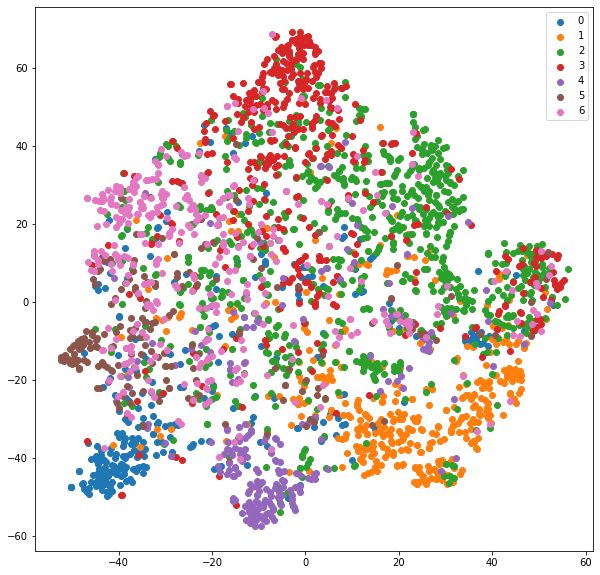

In [32]:
## Scatter plot representation for FNN model's prediction

x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)

**Evaluate GCNN model**

In [33]:
# Evaluate GCNN model

y_pred_gcnn = model_gcnn.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred_gcnn,axis=1), target_names=classes)
print('GCNN Classification Report: \n {}'.format(report))

# Subset accuracy --> 1 if the prediction for one sample fully matches, 0 otherwise
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(np.argmax(y_te,axis=1), np.argmax(y_pred_gcnn,axis=1), normalize=True, sample_weight=None)))

GCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.89      0.85      0.87       122
    Genetic_Algorithms       0.93      0.89      0.91       177
       Neural_Networks       0.91      0.72      0.80       290
 Probabilistic_Methods       0.77      0.73      0.75       144
Reinforcement_Learning       0.66      0.83      0.73        65
         Rule_Learning       0.47      0.87      0.61        63
                Theory       0.65      0.69      0.67       139

              accuracy                           0.78      1000
             macro avg       0.75      0.80      0.76      1000
          weighted avg       0.81      0.78      0.79      1000

Subset accuracy: 0.781


In [34]:
## Get hidden layer representation for GCNN model
layer_outputs = [layer.output for layer in model_gcnn.layers]
activation_model = Model(inputs=model_gcnn.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCNN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


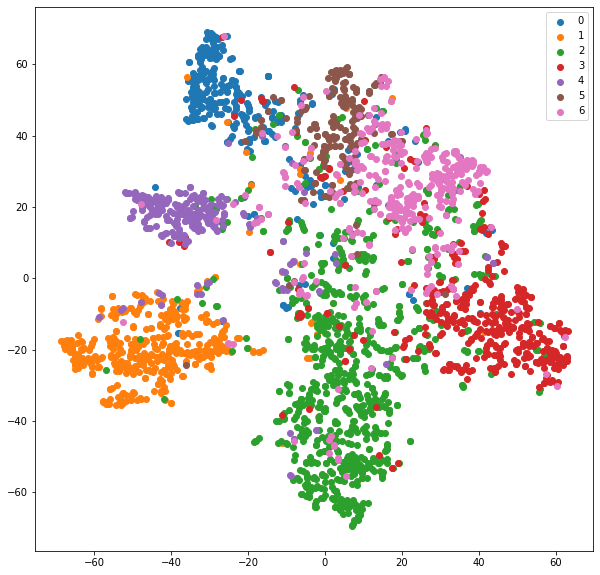

In [35]:
## Scatter plot representation for GCNN model's prediction

plot_tSNE(labels_encoded,x_tsne)

**After observing the results of both the models, GCNN performed better than FNN as subset accuracy of GCNN is higher than a subset accuracy of FNN**

### **4. Export predictions in a TSV file in the format `<paper_id> <class_label>`**

In [36]:
predictions = np.argmax(y_pred_gcnn, axis = 1)

In [37]:
y_pred = label_encoder.inverse_transform(predictions)

In [38]:
tsv_df = pd.DataFrame(columns=['class_label'])


In [43]:
tsv_df['class_label'] = y_pred.tolist()

In [46]:
tsv_df.to_csv('/content/prediction.tsv', sep="\t")

[]